In [1]:
# notebook to obtain results for Figure 6 of https://arxiv.org/pdf/2508.05390

In [2]:
from typing import Callable
from typing import Sequence
import pandas
import numpy
from numpy.typing import NDArray
import matplotlib.pyplot as plt

import scipy
from scipy.optimize import minimize
from scipy.sparse.linalg import expm_multiply

from pytket.extensions.qiskit import AerBackend

In [ ]:

def convert_df_to_qubitoperator(hamiltonian: pandas.DataFrame):
    """ function to convert a Pandas dataframe (here loaded from a csv file) to InQuanto QubitOperator.

    Should return an InQuanto QubitOperator.

    For more information on QubitOperator, see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.QubitOperator
    """
    pass


class MultiConfigurationStateSparse():
    """ 
    Class to build an non-symbolic ansatz object specifying a selected linear combination of occupation configurations.

    Instantiated from a QubitState (dictionary-like object storing configurations and coefficients of a state vector).

    This is the SSP method, based on Gleinig and Hoefler’s 2021 IEEE paper https://ieeexplore.ieee.org/document/9586240.

    Should have a method to return a non-symbolic circuit representing the state vector
    - see https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.GeneralAnsatz.get_circuit

    See https://docs.quantinuum.com/inquanto/api/inquanto/ansatz.html#inquanto.ansatzes.MultiConfigurationStateSparse.

    """
    def __init__(QubitState):
        pass

    def get_circuit():
        pass

    pass


class QubitState():
    """ Object that specifies a state vector in the computational basis, stored as a dictionary. 
    
    Maps a occupation configuration (key) to its coefficient (value).

    Should have a method to convert to a numpy nd array.

    Should have a method to normalize the coefficients (using the 2-norm). 

    See https://docs.quantinuum.com/inquanto/api/inquanto/states.html#inquanto.states.QubitState
    """
    def __init__({occupation_configuration: coefficient}):
        pass

    def normalized():
        pass

    def to_ndarray():
        pass

    pass


In [3]:
# 1 dets
state1_angle80_1det = QubitState(
        {
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]: 1.0,
        }
    ).normalized()

# 2 dets
state1_angle80_2det = QubitState(
        {
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]: 0.821254196154,
            [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]: -0.558136060804,
        }
    ).normalized()

# 4 dets
state1_angle80_4det = QubitState(
        {
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]: 0.821254196154,
            [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]: -0.558136060804,
            [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]: 0.064294888532,
            [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]: -0.064294828268,
        }
    ).normalized()
# 8 dets
state1_angle80_8det = QubitState(
        {
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]: 0.821254196154,
            [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]: -0.558136060804,
            [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]: 0.064294888532,
            [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]: -0.064294828268,
            [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]: -0.046385335538,
            [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]: 0.046385180785,
            [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]: -0.017591683422,
            [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]: -0.016192896134,
        }
    ).normalized()

sv1 = state1_angle80_1det.to_ndarray().flatten()
sv2 = state1_angle80_2det.to_ndarray().flatten()
sv4 = state1_angle80_4det.to_ndarray().flatten()
sv8 = state1_angle80_8det.to_ndarray().flatten()

In [4]:
# prepare circuits for 4dets and 8dets

# ON-4
mc_on4 = MultiConfigurationStateSparse(state1_angle80_4det)
circ_comp_on4 = AerBackend().get_compiled_circuit(mc_on4.get_circuit(None), optimisation_level=1)
print("number of 2-qubit gates for ON-4:", circ_comp_on4.n_2qb_gates())

# ON-8
mc_on8 = MultiConfigurationStateSparse(state1_angle80_8det)
circ_comp_on8 = AerBackend().get_compiled_circuit(mc_on8.get_circuit(None), optimisation_level=1)
print("number of 2-qubit gates for ON-8:", circ_comp_on8.n_2qb_gates())

number of 2-qubit gates for ON-4: 13
number of 2-qubit gates for ON-8: 40


In [5]:
def operator_center_transformation(hamiltonian: pandas.DataFrame):
    operator = convert_df_to_qubitoperator(hamiltonian)
    b = operator.get(QubitOperatorString(), 0)  # For info on InQuanto QubitOperatorString see https://docs.quantinuum.com/inquanto/api/inquanto/operators.html#inquanto.operators.QubitOperatorString
    shifted_operator = operator - b * QubitOperator.identity()

    return shifted_operator, b


def get_phase_function(times: Sequence[float], overlaps: Sequence[complex]
) -> Callable[[float], float]:
    def f(theta):
        return (
                abs(
                    sum(
                        [
                            o * numpy.exp(1.0j * t * theta)
                            for t, o in zip(times, overlaps)
                        ]
                    )
                )
                ** 2
        )

    return f


def get_qcles_energy(times: Sequence[float], overlaps: Sequence[complex], x0: float) -> float:
    f = get_phase_function(times, overlaps)
    res = minimize(
        lambda x: -f(x),
        x0=x0,
        method="BFGS",
        tol=1.0e-6
    )

    # print("BFGS RESULTS:")
    # print(res)

    return res.x.item()


def get_qcles_data(
    times: Sequence[float], overlaps: Sequence[complex], x0: float, w: float, num_points: int = 1001
) -> tuple[float, float, float]:
    f = get_phase_function(times, overlaps)
    energies = numpy.linspace(x0 - w, x0 + w, num_points)
    landscape = numpy.asarray([f(p) for p in energies])

    return energies, landscape


def evolve(times, svi):
    return numpy.asarray([numpy.vdot(svi, expm_multiply(-1.0j * t * hmat, svi)) for t in times])


def eigen_select(
    a: scipy.sparse.csc_matrix,
    k: int,
    hamming_weight: int,
    idx=0,
    threshold: float = 1e-5,
) -> NDArray[numpy.float64]:


    e, c = scipy.sparse.linalg.eigsh(a, k, which="SA")
    order = numpy.argsort(numpy.real(e))
    e = e[order]
    c = c[:, order]

    ls = []
    cs = []
    for i, ci in enumerate(c.T):
        satisfy_condition = True
        for j, cij in enumerate(numpy.array(ci).reshape(-1)):
            if numpy.abs(cij) > threshold:
                if bin(j).count("1") != hamming_weight:
                    satisfy_condition = False
                    break
        if satisfy_condition:
            ls.append(e[i])
            cs.append(c[:, i])

    return numpy.array(ls)[idx], numpy.array(cs)[idx]


In [6]:
# the hamiltonians stored in hams/ directory as csv files were generated using the active space specified in section 3.1.3 of https://arxiv.org/pdf/2508.05390v1
# frozen = [[0, 1, 2, 3, 6, 10, 11, 12], [0, 1, 2, 3, 6, 10, 11, 12]]
# where the first inner list represents spin up, and second inner list represents spin down, 
# i.e. frozen = [[spin up orbitals...], [spin down orbitals...]]
# therefore for the 12 spin orbital (12 qubit) active space, orbitals 4, 5, 7, 8, 9, and 13 are unfrozen.
# These fermionic Hamiltonians are Jordan-Wigner transformed before converting to csv.


h = pandas.read_csv(f"hams/ham_c2h4_12qubit_angle{80}.csv")
h_centered, h0 = operator_center_transformation(h)
qubits = list(sorted(h_centered.all_qubits))

hmat = h_centered.to_sparse_matrix(qubits)

e0, sv0 = eigen_select(hmat, k=10, hamming_weight=6, idx=0)
print("Ground state energy:", e0)
print(h0)

Ground state energy: -2.677965902614521
-74.31590521421175


In [7]:
times = numpy.linspace(0, 3, 31)

print("Evolving with times:", times)
z0 = evolve(times, sv0)
z1 = evolve(times, sv1)
z2 = evolve(times, sv2)
z4 = evolve(times, sv4)
z8 = evolve(times, sv8)

pandas.DataFrame({
    "time": times,
    "z0re": z0.real,
    "z0im": z0.imag,
    "z1re": z1.real,
    "z1im": z1.imag,
    "z2re": z2.real,
    "z2im": z2.imag,
    "z4re": z4.real,
    "z4im": z4.imag,
    "z8re": z8.real,
    "z8im": z8.imag,
}).to_csv("qcels_z.csv", index=False)

w = 0.2
ef0, f0 = get_qcles_data(times, z0, e0, w)
ef1, f1 = get_qcles_data(times, z1, e0, w)
ef2, f2 = get_qcles_data(times, z2, e0, w)
ef4, f4 = get_qcles_data(times, z4, e0, w)
ef8, f8 = get_qcles_data(times, z8, e0, w)

pandas.DataFrame({
    "ef0": ef0 + h0,
    "f0": f0,
    "ef1": ef1 + h0,
    "f1": f1,
    "ef2": ef2 + h0,
    "f2": f2,
    "ef4": ef4 + h0,
    "f4": f4,
    "ef8": ef8 + h0,
    "f8": f8,
}).to_csv("qcels_energy.csv", index=False)



data = []
for t in times[1:]:
    print(f"Processing time {t:.2f}", end="\r")
    red_times = numpy.linspace(0, t, 31)

    z0 = evolve(red_times, sv0)
    z1 = evolve(red_times, sv1)
    z2 = evolve(red_times, sv2)
    z4 = evolve(red_times, sv4)
    z8 = evolve(red_times, sv8)

    est0 = get_qcles_energy(red_times, z0, e0) + h0
    est1 = get_qcles_energy(red_times, z1, e0) + h0
    est2 = get_qcles_energy(red_times, z2, e0) + h0
    est4 = get_qcles_energy(red_times, z4, e0) + h0
    est8 = get_qcles_energy(red_times, z8, e0) + h0

    data.append({
        "time": t,
        "est0": est0,
        "est1": est1,
        "est2": est2,
        "est4": est4,
        "est8": est8,
    })

pandas.concat([pandas.DataFrame([i]) for i in data], ignore_index=True).to_csv("qcels_data.csv", index=False)


Evolving with times: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
Processing time 3.00

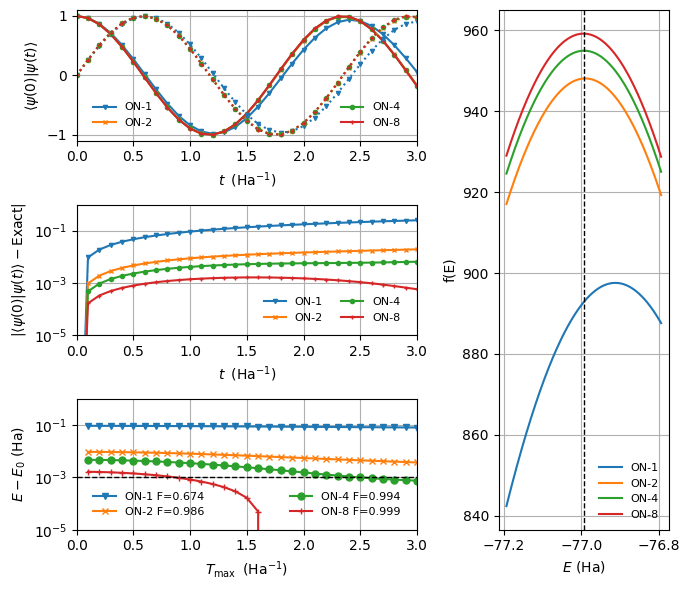

In [8]:
dfd = pandas.read_csv("qcels_data.csv")
dfe = pandas.read_csv("qcels_energy.csv")
dfz = pandas.read_csv("qcels_z.csv")

fig = plt.figure(figsize=(7, 6))
gs = fig.add_gridspec(3, 2, width_ratios=[4, 2])

ax_re, ax_se, ax_qcels = (fig.add_subplot(gs[i, 0]) for i in range(3))
ax_big = fig.add_subplot(gs[:, 1])

ax_re.plot(dfz.time, dfz.z1re, label='ON-1', color='tab:blue', marker='v', markersize=3)
ax_re.plot(dfz.time, dfz.z2re, label='ON-2', color='tab:orange', marker='x', markersize=3)
ax_re.plot(dfz.time, dfz.z4re, label='ON-4', color='tab:green', marker='o', markersize=3)
ax_re.plot(dfz.time, dfz.z8re, label='ON-8', color='tab:red', marker='+', markersize=3)

ax_re.plot(dfz.time, dfz.z1im, linestyle=':', color='tab:blue', marker='v', markersize=3)
ax_re.plot(dfz.time, dfz.z2im, linestyle=':', color='tab:orange', marker='x', markersize=3)
ax_re.plot(dfz.time, dfz.z4im, linestyle=':', color='tab:green', marker='o', markersize=3)
ax_re.plot(dfz.time, dfz.z8im, linestyle=':' , color='tab:red', marker='+', markersize=3)
ax_re.grid(True)
ax_re.set_ylabel(r'$\langle \psi(0)|\psi(t)\rangle$')
ax_re.set_xlim(0, max(dfz.time))
ax_re.set_xlabel(r'$t\;\;(\mathrm{Ha}^{-1})$')

handles, labels = ax_re.get_legend_handles_labels()
mid = len(labels) // 2
left_h, left_l   = handles[:mid], labels[:mid]
right_h, right_l = handles[mid:], labels[mid:]
leg_left = ax_re.legend(left_h, left_l, loc="lower left",bbox_to_anchor=(0.02, 0.02),fontsize=8, frameon=False)
ax_re.legend(right_h, right_l, loc="lower right",  bbox_to_anchor=(0.98, 0.02),  fontsize=8,  frameon=False)
ax_re.add_artist(leg_left)


ax_se.plot(dfz.time, numpy.sqrt((dfz.z1re - dfz.z0re)**2 + (dfz.z1im - dfz.z0im)**2), label='ON-1', color='tab:blue', marker='v', markersize=3)
ax_se.plot(dfz.time, numpy.sqrt((dfz.z2re - dfz.z0re)**2 + (dfz.z2im - dfz.z0im)**2), label='ON-2', color='tab:orange', marker='x', markersize=3)
ax_se.plot(dfz.time, numpy.sqrt((dfz.z4re - dfz.z0re)**2 + (dfz.z4im - dfz.z0im)**2), label='ON-4', color='tab:green', marker='o', markersize=3)
ax_se.plot(dfz.time, numpy.sqrt((dfz.z8re - dfz.z0re)**2 + (dfz.z8im - dfz.z0im)**2), label='ON-8', color='tab:red', marker='+', markersize=3)
ax_se.set_ylabel(r'$|\langle \psi(0)|\psi(t)\rangle - \mathrm{Exact}|$')

ax_se.set_xlabel(r'$t\;\;(\mathrm{Ha}^{-1})$')
ax_se.legend()
ax_se.set_ylim(1e-5, 1)
ax_se.set_xlim(0, max(dfz.time))
ax_se.set_yscale('log')
ax_se.grid(True)

handles, labels = ax_se.get_legend_handles_labels()
mid = len(labels) // 2
left_h, left_l   = handles[:mid], labels[:mid]
right_h, right_l = handles[mid:], labels[mid:]
leg_left = ax_se.legend(left_h, left_l, loc="lower left",bbox_to_anchor=(0.52, 0.02),fontsize=8, frameon=False)
ax_se.legend(right_h, right_l, loc="lower right",  bbox_to_anchor=(0.98, 0.02),  fontsize=8,  frameon=False)
ax_se.add_artist(leg_left)


ax_qcels.plot(dfd.time, dfd.est1 - dfd.est0, label=f"ON-1 F={0.674:.3g}", color='tab:blue', marker='v', markersize=5)
ax_qcels.plot(dfd.time, dfd.est2 - dfd.est0, label=f"ON-2 F={0.986:.3g}", color='tab:orange', marker='x', markersize=5)
ax_qcels.plot(dfd.time, dfd.est4 - dfd.est0, label=f"ON-4 F={0.994:.3g}", color='tab:green', marker='o', markersize=5)
ax_qcels.plot(dfd.time, dfd.est8 - dfd.est0, label=f"ON-8 F={0.999:.3g}", color='tab:red', marker='+', markersize=5)

ax_qcels.axhline(y=1e-3, color='k', linestyle='--', linewidth=1)
ax_qcels.grid(True)
ax_qcels.set_ylabel(r'$E-E_{0}$ (Ha)')
ax_qcels.set_yscale('log')
ax_qcels.set_xlabel(r'$T_{\text{max}}\;\;(\mathrm{Ha}^{-1})$')
ax_qcels.set_xlim(0, max(dfd.time))
ax_qcels.set_ylim(1e-5, 1)

handles, labels = ax_qcels.get_legend_handles_labels()
mid = len(labels) // 2
left_h, left_l   = handles[:mid], labels[:mid]
right_h, right_l = handles[mid:], labels[mid:]
leg_left = ax_qcels.legend(left_h, left_l, loc="lower left",bbox_to_anchor=(0.02, 0.02),fontsize=8, frameon=False)
ax_qcels.legend(right_h, right_l, loc="lower right",  bbox_to_anchor=(0.98, 0.02),  fontsize=8,  frameon=False)
ax_qcels.add_artist(leg_left)

ax_big.plot(dfe.ef1, dfe.f1, label='ON-1', color='tab:blue', markersize=5)
ax_big.plot(dfe.ef2, dfe.f2, label='ON-2', color='tab:orange', markersize=5)
ax_big.plot(dfe.ef4, dfe.f4, label='ON-4', color='tab:green', markersize=5)
ax_big.plot(dfe.ef8, dfe.f8, label='ON-8', color='tab:red', markersize=5)

ax_big.axvline(x=dfd.est0[0], color='k', linestyle='--', linewidth=1)
ax_big.grid(True)

ax_big.set_ylabel(r'f(E)')
ax_big.set_xlabel(r'$E$ (Ha)')
ax_big.legend(fontsize=8,  frameon=False)

plt.tight_layout()

fig.tight_layout()
# fig.savefig("angle80_time_evo_new.png", dpi=300, bbox_inches='tight')
# fig.savefig("angle80_time_evo_new.pdf", bbox_inches='tight')
plt.show()

# Fidelity (ON-1): 0.674458454700506
# Fidelity (ON-2): 0.9859743170700198
# Fidelity (ON-4): 0.994241974703406
# Fidelity (ON-8): 0.9991168362636319
# Energy (ON-1): 0.0945364318866444
# Energy (ON-2): 0.00955017584526141
# Energy (ON-4): 0.004753777693978112
# Energy (ON-8): 0.001660312197948599
# Evolving with times: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]